# Homework

The homework is to prepare a report for the Ministry of Transport, revealing the nature and characteristics of flight delays. The report should help identify problem areas and contribute to decision-making. Therefore, strive not to state general facts, but to show problems. For example, the fact "the average departure delay is 15 minutes" by itself says little and does not help to understand why this is happening. On the contrary, a graph showing that on Mondays delays increase threefold compared to other days against the background of an increase in the number of flights and passengers suggests a possible cause of the problem: airports cannot cope with uneven load.

The report should be in the form of a notebook with a clear structure. At the beginning of the Markdown cell there is a brief description of the question under study (what we will study), then the code and all its outputs (tables, graphs, values), then again in the Markdown cell in which your brief conclusion is formulated.

The report should contain at least **5 results** confirmed by graphs. For variety of material, use different types of diagrams. All graphs should be provided with the necessary signatures (axis designations, title, color scheme legend).

To solve the problems, use the methods of the `pandas` library.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
airlines = pd.read_csv('datasets/airlines.csv', low_memory=False).set_index("IATA_CODE")
airports = pd.read_csv('datasets/airports.csv', low_memory=False).set_index("IATA_CODE")
flights = pd.read_csv('datasets/flights.csv', low_memory=False)

Смотрим только на состоявшиеся рейсы<br>
также добавляем колонку разницы времени между реальной посадкой запланированой с учетом задержек

In [16]:
flights = flights[flights.CANCELLED==0].drop(columns=["YEAR", "TAIL_NUMBER", "DIVERTED", "CANCELLED", 
                                                                  "CANCELLATION_REASON", "FLIGHT_NUMBER", 
                                                                  "AIR_TIME", "TAXI_OUT", "TAXI_IN", 
                                                                  "WHEELS_OFF", "WHEELS_ON",
                                                                  "DEPARTURE_TIME", "ARRIVAL_TIME"])
flights = flights.fillna(0)
flights = flights.join(airports.STATE, on="ORIGIN_AIRPORT")
flights['MID_AIR_DELAY'] = flights.ARRIVAL_DELAY - flights.DEPARTURE_DELAY

In [17]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,STATE,MID_AIR_DELAY
0,1,1,4,AS,ANC,SEA,5,-11.0,205.0,194.0,1448,430,-22.0,0.0,0.0,0.0,0.0,0.0,AK,-11.0
1,1,1,4,AA,LAX,PBI,10,-8.0,280.0,279.0,2330,750,-9.0,0.0,0.0,0.0,0.0,0.0,CA,-1.0
2,1,1,4,US,SFO,CLT,20,-2.0,286.0,293.0,2296,806,5.0,0.0,0.0,0.0,0.0,0.0,CA,7.0
3,1,1,4,AA,LAX,MIA,20,-5.0,285.0,281.0,2342,805,-9.0,0.0,0.0,0.0,0.0,0.0,CA,-4.0
4,1,1,4,AS,SEA,ANC,25,-1.0,235.0,215.0,1448,320,-21.0,0.0,0.0,0.0,0.0,0.0,WA,-20.0


In [18]:
delays = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'MID_AIR_DELAY',
          'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

In [19]:
month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [20]:
flights[delays].mean()

AIR_SYSTEM_DELAY       2.502230
SECURITY_DELAY         0.014135
MID_AIR_DELAY         -4.943462
AIRLINE_DELAY          3.521080
LATE_AIRCRAFT_DELAY    4.356970
WEATHER_DELAY          0.541129
dtype: float64

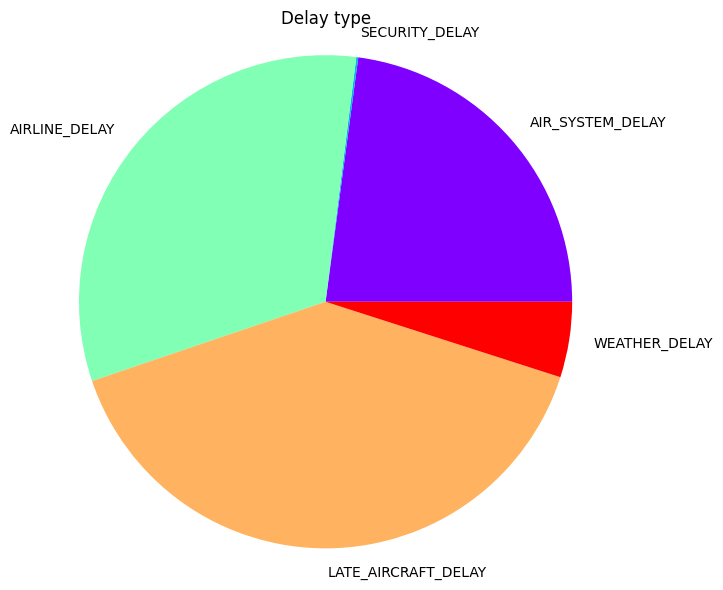

In [23]:
flights[delays].drop(columns='MID_AIR_DELAY').mean().plot.pie(figsize=(7,7), colormap='rainbow')
plt.axis('equal')
plt.title('Delay type')
plt.show()

Считаем величины разных типов задержек в разрезах штата откуда летим, месяца, дня недели, авиалиний и дистанции полёта

In [24]:
delay_by_state = flights.groupby("STATE")[delays].mean()

delay_by_month = flights.groupby("MONTH")[delays].mean()
delay_by_month.index = month_abbr

delay_by_week_day = flights.groupby("DAY_OF_WEEK")[delays].mean()
delay_by_week_day.index = day_abbr

delay_by_airline = flights.groupby("AIRLINE")[delays].mean()
delay_by_airline.index = airlines.AIRLINE

delay_by_distance = flights.groupby(pd.cut(flights.DISTANCE, bins=5))[delays].mean()
distance_ticks = delay_by_distance.index.map(lambda interval: str(int(interval.left)) + "-" + str(int(interval.right)))
delay_by_distance.index = distance_ticks


delay_info = {
    "State": delay_by_state, 
    "Month": delay_by_month, 
    "Day of the week": delay_by_week_day, 
    "Airline": delay_by_airline, 
    "Distance, km": delay_by_distance
}

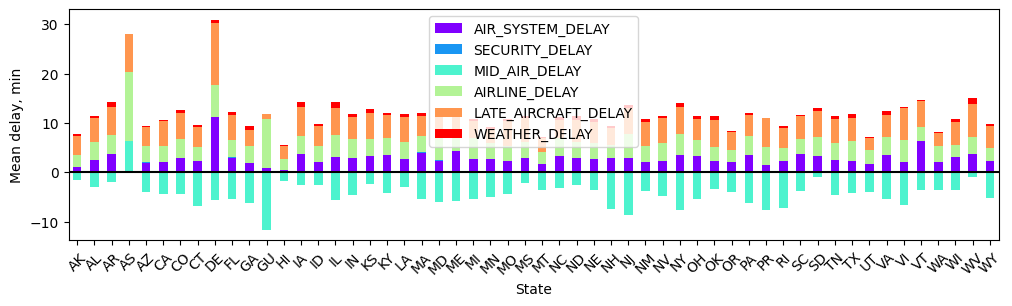

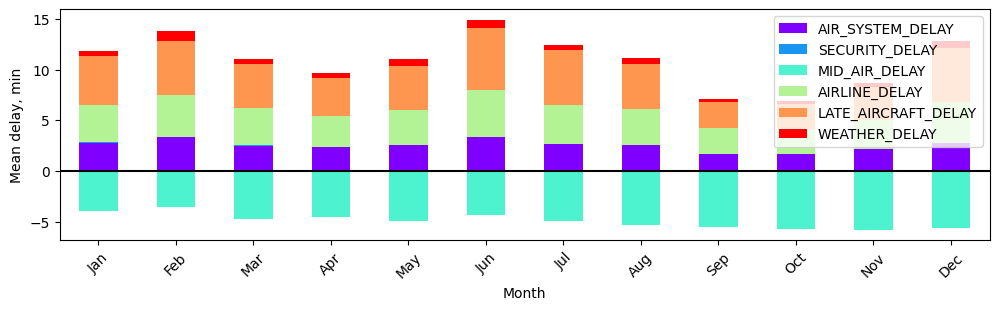

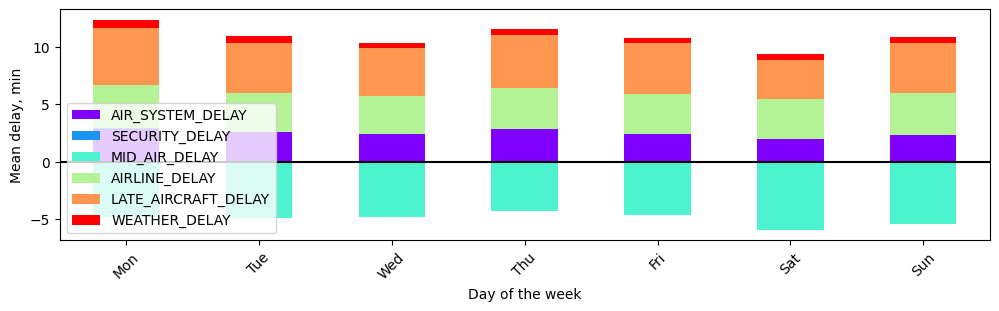

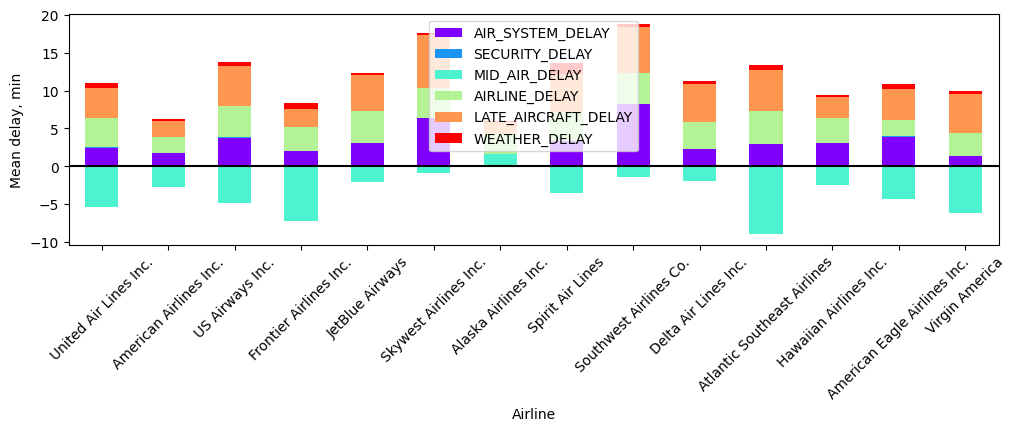

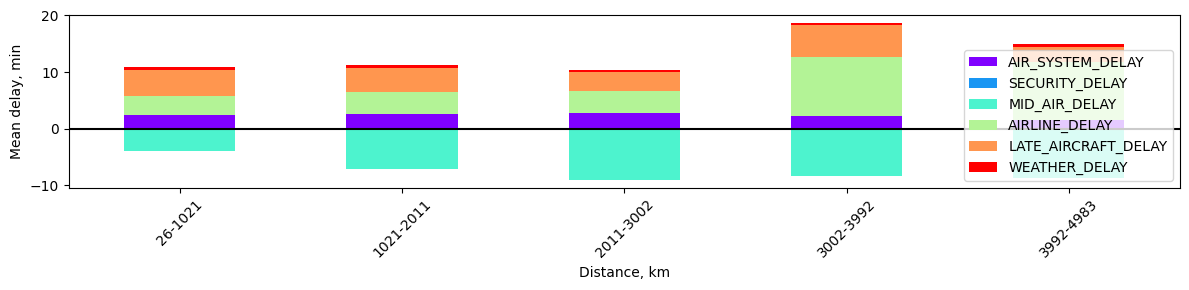

In [28]:
for delay, ax in zip(list(delay_info.items()), range(6)):
    ax = delay[1].plot.bar(figsize=(12,3), stacked=True, colormap='rainbow')
    plt.axhline(0, color='black')
    plt.xticks(rotation=45)
    ax.set(ylabel='Mean delay, min', xlabel=delay[0])
plt.tight_layout()
plt.show()

1. Самые долгие задержки происходят в аэропортах Делавэра, что может быть связано с высоким трафиков <br>
вблизи столицы Вашингтон, и таких мегаполисов, как Нью-Йорк и Филадельфия.<br>
<br>
2. По месяцам задержки примерно похожи, видны пики только в декабре и июне, т.е. в период праздников/отпусков.<br>
<br>
3. Alaska Airlines имеет самые низкие задержки, предположительно из-за расширения аэропорта и добавления новых <br>
маршрутов в конце 2014 г. (улучшение логистики, при еще не выросшем спросе).<br>
<br>
4. Начиная с расстояния в 3тыс. км, виден рост задержек, что скорее всего связано с логистическими сложностями ввиду <br>
большего времени полёта. <br>
<br>
5. Вклад погодных условий почти не виден, задержки в связи с безопасностью <br>
почти нет, ведь они возникают только в исключительных ситуациях. <br>
Время непосредственно полёта как правило меньше, чем планируется. <br>
Больше всего вклада в задержки вносят технические проблемы с самолётом. <br>
<br>